# Hands-on: Training the AIFS-ENS with Anemoi


This notebook can be used to run inference on the checkpoint you've just trained yourself.

**Resources:**

[anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

In [1]:
from pathlib import Path
import subprocess
import torch
import warnings
import copy
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
from anemoi.inference.checkpoint import Checkpoint
from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from helpers import find_nearest_point_index

## Find your checkpoint

The location of the checkpoint you've just trained is printed in the terminal log, e.g. 
```
Checkpoints path: /home/student1/anemoi-output/checkpoint/HASHNUMBER
```

Replace the `PATH-TO-CHECKPOINT` below with the path to your trained checkpoint. 

In [3]:
print("Loading checkpoint...")
ckpt_file = "PATH-TO-CHECKPOINT/inference-last.ckpt"
ckpt = Checkpoint(ckpt_file)

# Variables used during training:
print("Number of variables:", len(ckpt.variable_categories()))
print(f"Diagnostic variables: {ckpt.diagnostic_variables}")
print(f"Prognostic variables: {ckpt.prognostic_variables}")

Loading checkpoint...
Number of variables: 23
Diagnostic variables: ['cp', 'tp']
Prognostic variables: ['z_1000', 'z_500', 'z_700', 'z_300', '2t', 't_850', 'tcw', 'z_250']


## Get initial conditions


Running the model for inference requires initial conditions. We retrieve Initial Conditions from ECMWF Open Data.




In [4]:
import datetime
from collections import defaultdict
from pathlib import Path

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from ecmwf.opendata import Client as OpendataClient
from helpers import load_saved_state, save_state

In [5]:
R = 6371.0  # Earth radius in km

GRID_RESOLUTION = "O48"
PARAM_SFC = ["2t", 'z', 'lsm', "tcw", "sdor", "slor"]
PARAM_PL = ["gh", "t"]
LEVELS = [1000, 850, 700, 500, 300, 250]

DATE = OpendataClient().latest()
print("Initial date is", DATE)

Initial date is 2026-02-26 00:00:00


In [6]:
def get_open_data(param, levelist=[], reference_date=DATE):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [reference_date - datetime.timedelta(hours=6), reference_date]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721, 1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to grid
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": GRID_RESOLUTION})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. 

To get different ensemble initial conditions from the ifs pertubation, set `number` to an ensemble number, between 1-50.


In [7]:
file = Path(f"inputstate-{GRID_RESOLUTION}-{DATE.strftime('%Y%m%d_%H')}.npz")
if file.exists():
    input_state = load_saved_state(file)
    print(f"Input state loaded from file {file}")
else:
    fields = {}
    # Surface fields
    fields.update(get_open_data(param=PARAM_SFC, reference_date=DATE))
    # Pressure levels fields
    fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS, reference_date=DATE))

    # Convert geopotential height into geopotential
    for level in LEVELS:
        gh = fields.pop(f"gh_{level}")
        fields[f"z_{level}"] = gh * 9.80665
    
    input_state = dict(date=DATE, fields=fields)

    print(f"State created for date {DATE}")
    save_state(input_state, file)

    print(f"State saved to file {file}")

Input state loaded from file inputstate-O48-20260226_00.npz


In [8]:
updated_fields = {}
for key in input_state['fields'].keys():
    if key in ['z_1000', 'z_500', 'z_700', 'z_300', '2t', 't_850', 'tcw', 'z_250', 'lsm', 'z', 'sdor', 'slor']:
        updated_fields[key] = input_state['fields'][key].copy()
input_state['fields'] = updated_fields

## Run inference from initial conditions

In [9]:
runner = SimpleRunner(ckpt_file)

In [10]:
LEAD_TIME = 240

### Run the forecast



In [11]:
from tqdm import tqdm
ens_members = 8 # This will become important tomorrow
forecast_states = [[] for nn in range(ens_members)]
for nn in range(ens_members):
    for step, state in tqdm(enumerate(runner.run(input_state=input_state, lead_time=LEAD_TIME)), total=int(LEAD_TIME/6)):
        # Store the state if you want to keep it
        forecast_states[nn].append(copy.deepcopy(state))

print(f"Forecast completed! Generated {len(forecast_states[0])} time steps.")

100%|██████████| 40/40 [00:02<00:00, 14.46it/s]

Forecast completed! Generated 40 time steps.


In [12]:
print(f"Predicted dates: {list(forecast_states[0][x]['date'].strftime('%Y-%m-%dT%H') for x in range(len(forecast_states[0])))}")

Predicted dates: ['2026-02-26T06', '2026-02-26T12', '2026-02-26T18', '2026-02-27T00', '2026-02-27T06', '2026-02-27T12', '2026-02-27T18', '2026-02-28T00', '2026-02-28T06', '2026-02-28T12', '2026-02-28T18', '2026-03-01T00', '2026-03-01T06', '2026-03-01T12', '2026-03-01T18', '2026-03-02T00', '2026-03-02T06', '2026-03-02T12', '2026-03-02T18', '2026-03-03T00', '2026-03-03T06', '2026-03-03T12', '2026-03-03T18', '2026-03-04T00', '2026-03-04T06', '2026-03-04T12', '2026-03-04T18', '2026-03-05T00', '2026-03-05T06', '2026-03-05T12', '2026-03-05T18', '2026-03-06T00', '2026-03-06T06', '2026-03-06T12', '2026-03-06T18', '2026-03-07T00', '2026-03-07T06', '2026-03-07T12', '2026-03-07T18', '2026-03-08T00']


# 4. Inspect the generated forecast

### Plot a field

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

In [14]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

# pick a state of the first ensemble members
variable = "2t"
state = forecast_states[0][-1]
date = state['date']
latitudes = state["latitudes"]
longitudes = fix(state["longitudes"])
values = state["fields"][variable]

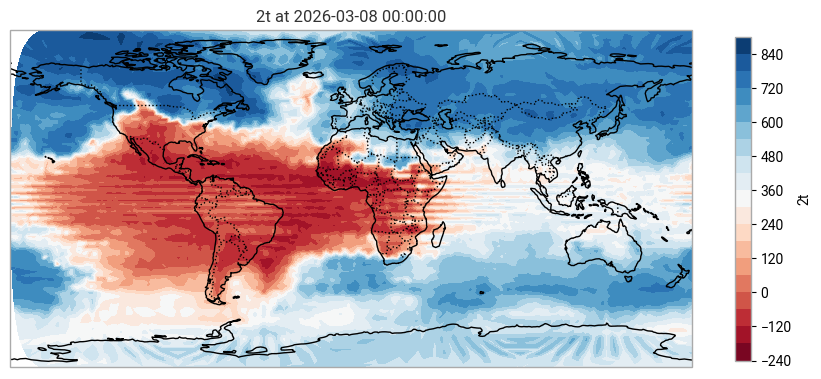

In [15]:
fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="2t")

plt.title("{} at {}".format(variable, state["date"]))
plt.show()


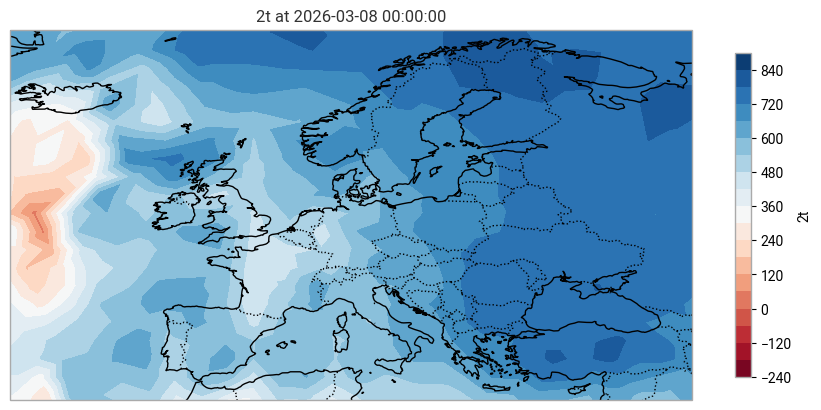

In [16]:
fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Limit the map to Europe
ax.set_extent([-25, 45, 34, 72], crs=ccrs.PlateCarree())

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="2t")

plt.title("{} at {}".format(variable, state["date"]))
plt.show()

### Plot a forecast time-series 

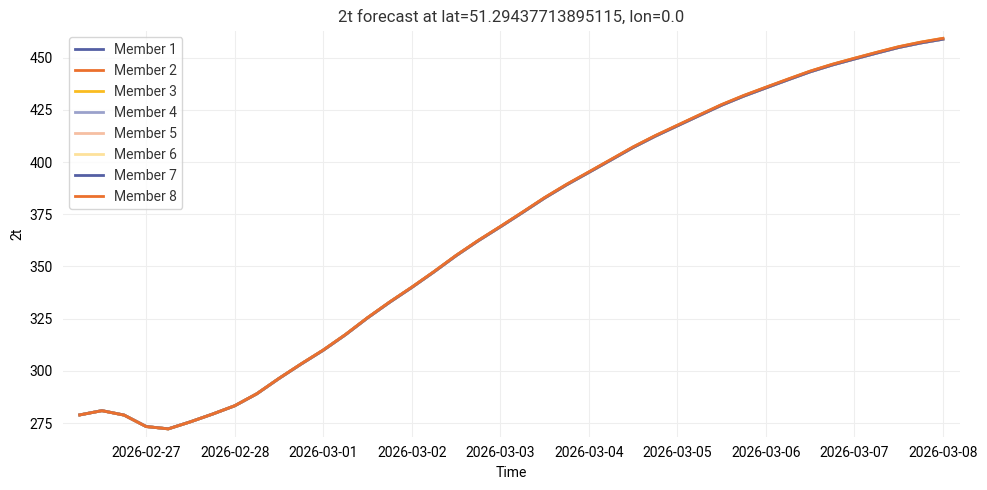

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lat_target = 51.45
lon_target = -0.98
idx_nearest = find_nearest_point_index(latitudes, longitudes, lat_target, lon_target)


lead_times = range(len(forecast_states[0]))

# Extract field for all members and times
values = np.array([
    [forecast_states[m][t]["fields"][variable][idx_nearest] for t in lead_times]
    for m in range(ens_members)
])

# Time axis
times = [forecast_states[0][t]["date"] for t in lead_times]
times = pd.to_datetime(times)

# Plot
plt.figure(figsize=(10, 5))

for m in range(ens_members):
    plt.plot(times, values[m, :], linewidth=2, label=f"Member {m+1}")

plt.title(f"{variable} forecast at lat={latitudes[idx_nearest]}, lon={longitudes[idx_nearest]}")
plt.xlabel("Time")
plt.ylabel(variable)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()